In [6]:
import requests
import os
import scanpy as sc
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import gc


In [7]:
import scanpy as sc
print(sc.__version__)

1.9.8


## Set parameters and paths

In [8]:
# Define parameters
res = 1
n_hvg = 2000

In [9]:
# Define the input and output directories
input_dir = 'Input_files'
output_dir = 'Output_Gabritto_2024'

# Create the output directory if it does not exist
if not os.path.exists(input_dir):
    os.makedirs(input_dir)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

## Analysis for Gabritto_2024

### Load data

In [11]:
studyID = 'Gabritto_2024'
download_link = 'https://datasets.cellxgene.cziscience.com/145aadbe-fd91-4592-bf14-3b4c644a2141.h5ad'
new_filename = f"Input_files/{studyID}.h5ad"
response = requests.get(download_link)
with open(new_filename, 'wb') as f:
        f.write(response.content)
print(f"File downloaded and saved as {new_filename}")

File downloaded and saved as Input_files/Gabritto_2024.h5ad


In [12]:
file = 'Gabritto_2024.h5ad'
print(f'Start process {studyID}')
adata=sc.read_h5ad(os.path.join(input_dir,file))
adata

Start process Gabritto_2024


AnnData object with n_obs × n_vars = 42486 × 36412
    obs: 'assay_ontology_term_id', 'suspension_type', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'is_primary_data', 'donor_id', 'Neurotypical reference', 'Class', 'Subclass', 'Supertype', 'Age at death', 'Years of education', 'Cognitive status', 'ADNC', 'Braak stage', 'Thal phase', 'CERAD score', 'APOE4 status', 'Lewy body disease pathology', 'LATE-NC stage', 'Microinfarct pathology', 'Specimen ID', 'PMI', 'Number of UMIs', 'Genes detected', 'Fraction mitochrondrial UMIs', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length'
    uns: 'ADNC_colors', 'APOE4 status_color

### Preprocess and clustering

Start process Gabritto_2024
    Before process: number of obs 42486, number of var 36412
    Start QC


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


    After process: number of obs 42483, number of var 31747
    It is Normalized and Log-Transformed data, no need to run normalization


/Users/yelin.zhao/opt/anaconda3/envs/py3_9_R4_30/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby("mean_bin")["dispersions"]
/Users/yelin.zhao/opt/anaconda3/envs/py3_9_R4_30/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:553: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["hvg"] = {"flavor": flavor}


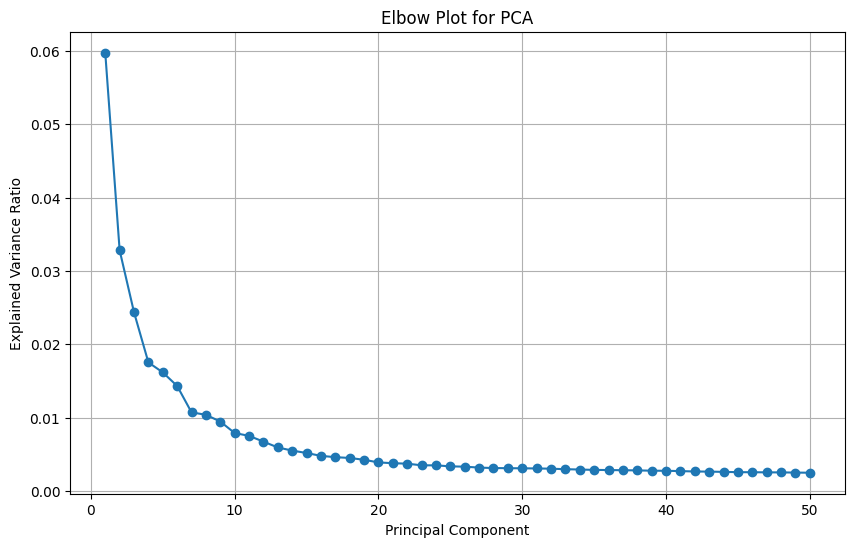

/Users/yelin.zhao/opt/anaconda3/envs/py3_9_R4_30/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
file = 'Gabritto_2024.h5ad'
print(f'Start process {studyID}')
adata=sc.read_h5ad(os.path.join(input_dir,file))
print(f'    Before process: number of obs {adata.n_obs}, number of var {adata.n_vars}')

adata.layers["counts"]=adata.X.copy()
adata.var['GeneID']=adata.var.index
adata.var.set_index('feature_name',inplace=True)
if adata.raw is not None:
    adata.raw.var.set_index('feature_name', inplace=True)
else:
    print("    adata.raw is None, skipping setting index.")
adata.var["mt"]=adata.var_names.str.startswith("MT-")

adata.obs['nCount_RNA'] = adata.obs['Number of UMIs']
adata.obs['nFeature_RNA'] = adata.obs['Genes detected']
del adata.obs['Number of UMIs']
del adata.obs['Genes detected']

# QC
print(f'    Start QC')
sc.pp.calculate_qc_metrics(adata,qc_vars=["mt"],inplace=True,log1p=True)
sc.pp.filter_genes(adata,min_cells=3)
adata=adata[adata.obs['nFeature_RNA']>200,:]
adata=adata[adata.obs['pct_counts_mt']<10,:]
adata=adata[adata.obs['nCount_RNA']>400,:]
adata=adata[adata.obs['nCount_RNA']<60000,:]
print(f'    After process: number of obs {adata.n_obs}, number of var {adata.n_vars}')

print(f'    It is Normalized and Log-Transformed data, no need to run normalization')

sc.pp.highly_variable_genes(adata,n_top_genes=n_hvg)
sc.tl.pca(adata)
explained_variance_ratio = adata.uns['pca']['variance_ratio']
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Elbow Plot for PCA')
plt.grid(True)
plt.show()
sc.pp.neighbors(adata,n_neighbors=10,n_pcs=30)
sc.tl.umap(adata)
sc.tl.leiden(adata,resolution=res,n_iterations=2)

### Remove non-microglials

/Users/yelin.zhao/opt/anaconda3/envs/py3_9_R4_30/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/Users/yelin.zhao/opt/anaconda3/envs/py3_9_R4_30/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
/Users/yelin.zhao/opt/anaconda3/envs/py3_9_R4_30/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap'

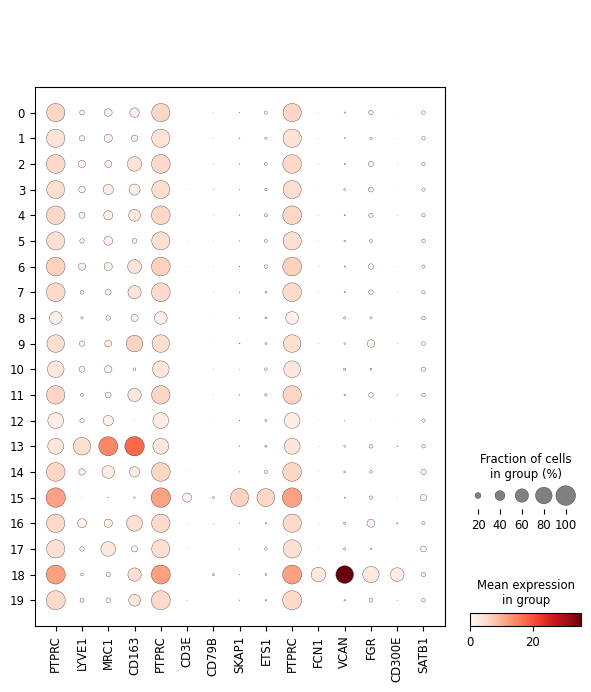

In [15]:
goi=['PTPRC', 'LYVE1', 'MRC1', 'CD163','PTPRC', 'CD3E', 'CD79B', 'SKAP1', 'ETS1','PTPRC', 'FCN1', 'VCAN', 'FGR', 'CD300E','SATB1']
goi_in_adata=[gene for gene in goi if gene in adata.var_names]
sc.pl.dotplot(adata, goi_in_adata, groupby="leiden");

In [16]:
# remove clusters
clusters_to_remove = ['13', '15', '18']
adata = adata[~adata.obs['leiden'].isin(clusters_to_remove), :]
adata

View of AnnData object with n_obs × n_vars = 40754 × 31747
    obs: 'assay_ontology_term_id', 'suspension_type', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'is_primary_data', 'donor_id', 'Neurotypical reference', 'Class', 'Subclass', 'Supertype', 'Age at death', 'Years of education', 'Cognitive status', 'ADNC', 'Braak stage', 'Thal phase', 'CERAD score', 'APOE4 status', 'Lewy body disease pathology', 'LATE-NC stage', 'Microinfarct pathology', 'Specimen ID', 'PMI', 'Fraction mitochrondrial UMIs', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'nCount_RNA', 'nFeature_RNA', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes'

/Users/yelin.zhao/opt/anaconda3/envs/py3_9_R4_30/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby("mean_bin")["dispersions"]
/Users/yelin.zhao/opt/anaconda3/envs/py3_9_R4_30/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:553: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["hvg"] = {"flavor": flavor}


/Users/yelin.zhao/opt/anaconda3/envs/py3_9_R4_30/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/yelin.zhao/opt/anaconda3/envs/py3_9_R4_30/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


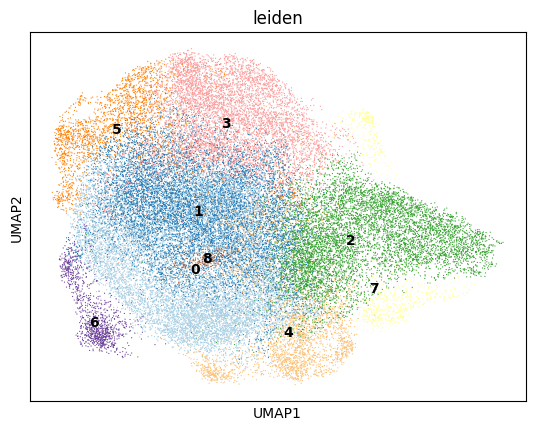

In [17]:
# Reclustering
import scanpy as sc
import matplotlib.pyplot as plt
res = 0.4
sc.pp.highly_variable_genes(adata,n_top_genes=n_hvg)
sc.tl.pca(adata)
sc.pp.neighbors(adata,n_neighbors=10,n_pcs=30)
sc.tl.umap(adata)
sc.tl.leiden(adata,resolution=res,n_iterations=2)

### Figure 7F

/Users/yelin.zhao/opt/anaconda3/envs/py3_9_R4_30/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/yelin.zhao/opt/anaconda3/envs/py3_9_R4_30/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


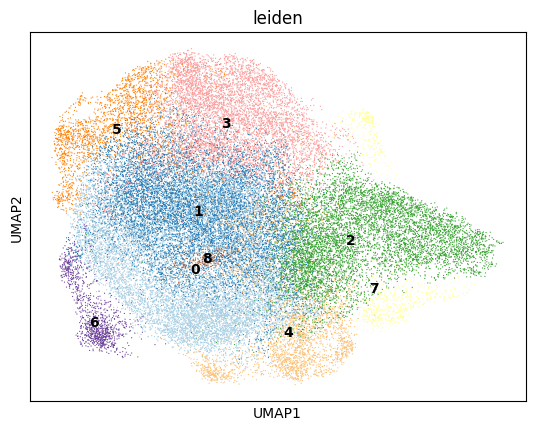

In [20]:
sc.pl.umap(adata, color=['leiden'], palette='Paired',legend_loc='on data', save=f'_{studyID}_microglia_leiden_res{res}.pdf')    

/Users/yelin.zhao/opt/anaconda3/envs/py3_9_R4_30/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/Users/yelin.zhao/opt/anaconda3/envs/py3_9_R4_30/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
/Users/yelin.zhao/opt/anaconda3/envs/py3_9_R4_30/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap'

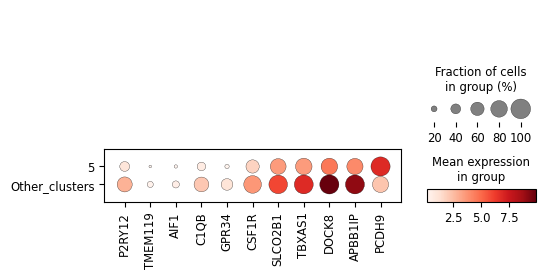

In [19]:
goi=['P2RY12','TMEM119','AIF1','C1QB','CX3R1','GPR34','CSF1R','SLCO2B1','TBXAS1','DOCK8','APBB1IP','PCDH9']

# Create a new variable 'cluster2' in adata.obs
adata.obs['cluster2'] = adata.obs['leiden'].apply(lambda x: '5' if x == '5' else 'Other_clusters')
adata.obs['cluster2'] = adata.obs['cluster2'].astype('category')

goi_in_adata=[gene for gene in goi if gene in adata.var_names]
sc.pl.dotplot(adata, goi_in_adata, groupby="cluster2",save=f'{studyID}_microglia_goi_res{res}_check_microgliaMarker.pdf')

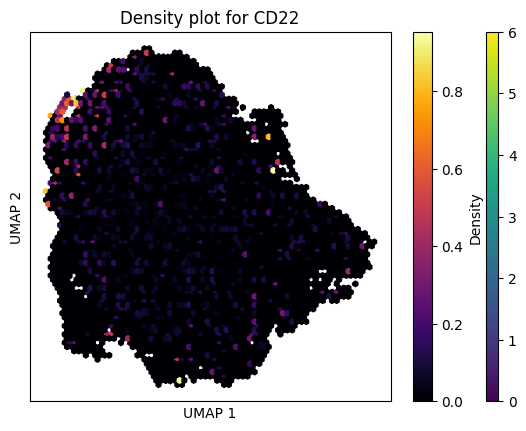

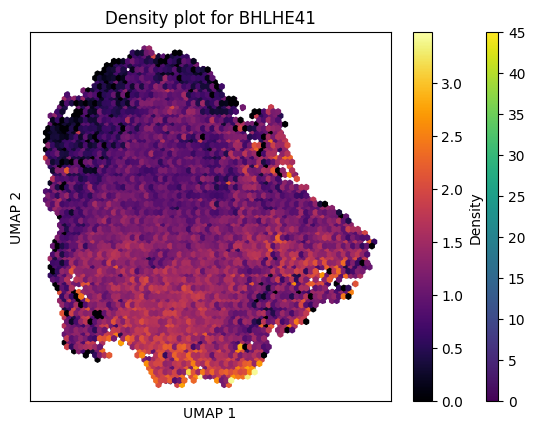

In [21]:
# Importing necessary libraries
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt

# Define the markers you are interested in
markers = ["CD22",'BHLHE41']

# Loop over each marker to create a density plot on UMAP
for marker in markers:
    # Create a UMAP scatter plot colored by marker expression
    sc.pl.umap(adata, color=marker, show=False, cmap='viridis', legend_loc=None,s=20)
    
    # Overlay density (this step is similar to Nebulosa, but done manually)
    ax = plt.gca()  # Get current axis
    
    # Extract UMAP coordinates
    x = adata.obsm['X_umap'][:, 0]  # UMAP 1 coordinates
    y = adata.obsm['X_umap'][:, 1]  # UMAP 2 coordinates
    
    # Extract expression levels of the marker
    expression = adata[:, marker].X.toarray().flatten()
    
   # Create a 2D histogram / density plot
    hexbin_plot = ax.hexbin(x, y, C=expression, gridsize=70, cmap='inferno', reduce_C_function=np.mean, mincnt=1)

    # Set axis labels and title
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    plt.title(f'Density plot for {marker}')

    # Add the colorbar with the mappable hexbin plot
    plt.colorbar(hexbin_plot, label='Density')
    
    # Save or show the figure
    plt.savefig(f'figures/umap_density_{studyID}_{marker}_within_macrolia.pdf')
    plt.show()

#### BHLHE41/CD22 in different clusters

Median value: Group
Cluster 5         0.693147
Other Clusters    4.886238
Name: BHLHE41_CD22_Ratio, dtype: float32
1.8236269490878746e-284


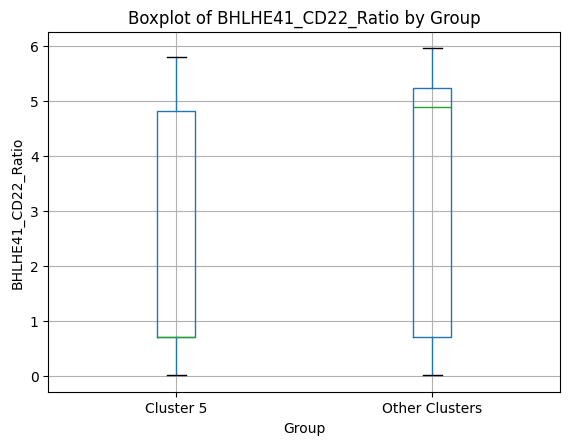

In [24]:
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import fisher_exact
from scipy.stats import ttest_ind

# Select cells from Leiden cluster 5 and all other clusters
cluster_5_cells = adata[adata.obs['leiden'] == '5']
other_clusters_cells = adata[adata.obs['leiden'] != '5']

# Extract expression levels of BHLHE41 and CD22 for cluster 5 and other clusters
bhlhe41_expression_cluster_5 = cluster_5_cells[:, 'BHLHE41'].X.toarray().flatten()
cd22_expression_cluster_5 = cluster_5_cells[:, 'CD22'].X.toarray().flatten()

bhlhe41_expression_other_clusters = other_clusters_cells[:, 'BHLHE41'].X.toarray().flatten()
cd22_expression_other_clusters = other_clusters_cells[:, 'CD22'].X.toarray().flatten()

# Add 0.01 to the expression levels
bhlhe41_expression_cluster_5 += 0.01
cd22_expression_cluster_5 += 0.01

bhlhe41_expression_other_clusters += 0.01
cd22_expression_other_clusters += 0.01

# Calculate the value of BHLHE41/CD22
bhlhe41_cd22_ratio_cluster_5 = bhlhe41_expression_cluster_5 / cd22_expression_cluster_5
bhlhe41_cd22_ratio_other_clusters = bhlhe41_expression_other_clusters / cd22_expression_other_clusters

# Perform log transformation
bhlhe41_cd22_ratio_cluster_5_log = np.log1p(bhlhe41_cd22_ratio_cluster_5)
bhlhe41_cd22_ratio_other_clusters_log = np.log1p(bhlhe41_cd22_ratio_other_clusters)

# Create a DataFrame for plotting
data = {
    'BHLHE41_CD22_Ratio': np.concatenate([bhlhe41_cd22_ratio_cluster_5_log, bhlhe41_cd22_ratio_other_clusters_log]),
    'Group': ['Cluster 5'] * len(bhlhe41_cd22_ratio_cluster_5_log) + ['Other Clusters'] * len(bhlhe41_cd22_ratio_other_clusters_log)
}

df = pd.DataFrame(data)

# Calculate the median value for each group
median_values = df.groupby('Group')['BHLHE41_CD22_Ratio'].median()
print('Median value:',  median_values)

# Plot the data
fig, ax = plt.subplots()
df.boxplot(column='BHLHE41_CD22_Ratio', by='Group', ax=ax)

# Perform t-test to get the p-value between the two groups
t_stat, p_value = ttest_ind(bhlhe41_cd22_ratio_cluster_5_log, bhlhe41_cd22_ratio_other_clusters_log)
print(p_value)

plt.title('Boxplot of BHLHE41_CD22_Ratio by Group')
plt.suptitle('')
plt.xlabel('Group')
plt.ylabel('BHLHE41_CD22_Ratio')
plt.savefig(f'figures/{studyID}_microglia_Cluster5vsOthers.pdf')
plt.show()
